# Music Genre Classification

CS760 2022S2 P13 Group

---

Install package for converting MP3 to CSV:

In [1]:
#!conda install -c conda-forge librosa

---

# 1. Package Import

In [2]:
import pandas as pd
import librosa
import random
import sklearn.metrics as metrics
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import AgglomerativeClustering
import numpy as np
from scipy.cluster.hierarchy import dendrogram, linkage
from matplotlib import pyplot as plt
from matplotlib.colors import ListedColormap

In [3]:
random.seed(123)

---

# 2. Load Data

In [4]:
_30sec = pd.read_csv('Data/features_30_sec.csv')

---

# 3. Preprocessing

## 3.1 Load Data

Create features and labels sets, normalize the feature set, then perform PCA with 0.05 variance reduction. Finally convert to numpy matrix.

In [5]:
def preprocessing(data):
    X = data.iloc[:,19:59:2]
    y = data.iloc[:,-1]
    X = StandardScaler().fit_transform(X)
    pca = PCA(n_components = 0.95)
    X = pca.fit_transform(X)
    return X, y

In [6]:
X, y = preprocessing(_30sec)

## 3.2 MP3 TO CSV Function (Optional)

In [7]:
def mp3_to_df(filename):
    y,sr = librosa.load(filename)
    length = len(y)
    chroma_stft = librosa.feature.chroma_stft(y=y, sr=sr)
    chroma_stft_mean = chroma_stft.mean()
    chroma_stft_var = chroma_stft.var()
    rms = librosa.feature.rms(y=y)
    rms_mean = rms.mean()
    rms_var = rms.var()
    spectral_centroid = librosa.feature.spectral_centroid(y=y, sr=sr)
    spectral_centroid_mean = spectral_centroid.mean()
    spectral_centroid_var = spectral_centroid.var()
    spectral_bandwidth = librosa.feature.spectral_bandwidth(y=y, sr=sr)
    spectral_bandwidth_mean = spectral_bandwidth.mean()
    spectral_bandwidth_var = spectral_bandwidth.var()
    rolloff = librosa.feature.spectral_rolloff(y=y,sr=sr)
    rolloff_mean = rolloff.mean()
    rolloff_var = rolloff.var()
    zero_crossing_rate = librosa.feature.zero_crossing_rate(y=y)
    zero_crossing_rate_mean = zero_crossing_rate.mean()
    zero_crossing_rate_var = zero_crossing_rate.var()
    harmony = librosa.feature.tempogram(y=y, sr=sr)
    harmony_mean = harmony.mean()
    harmony_var = harmony.var()
    perceptr = librosa.effects.percussive(y=y)
    perceptr_mean = perceptr.mean()
    perceptr_var = perceptr.var()
    tempo = librosa.beat.tempo(y=y, sr=sr).mean()
    row = [[length,chroma_stft_mean,chroma_stft_var,
           rms_mean,rms_var,spectral_centroid_mean,
           spectral_centroid_var,spectral_bandwidth_mean,
           spectral_bandwidth_var,rolloff_mean,rolloff_var,
           zero_crossing_rate_mean,zero_crossing_rate_var,
           harmony_mean,harmony_var,perceptr_mean,
           perceptr_var,tempo]]
    df = pd.DataFrame(row, columns = 
                      ['length','chroma_stft_mean','chroma_stft_var',
                       'rms_mean','rms_var','spectral_centroid_mean',
                       'spectral_centroid_var','spectral_bandwidth_mean',
                       'spectral_bandwidth_var','rolloff_mean','rolloff_var',
                       'zero_crossing_rate_mean','zero_crossing_rate_var',
                       'harmony_mean','harmony_var','perceptr_mean',
                       'perceptr_var','tempo'])
    mfcc_arr = librosa.feature.mfcc(y=y, sr=sr)
    for i in range(len(mfcc_arr)):
        mean_colname = 'mfcc'+str(i+1)+'_mean'
        var_colname = 'mfcc'+str(i+1)+'_var'
        df[mean_colname] = mfcc_arr[i].mean()
        df[var_colname] = mfcc_arr[i].var()
    return df

## 3.3 View Groundtruth Clusters

In [8]:
X_og = _30sec.iloc[:,19:59:2]
X_t = StandardScaler().fit_transform(X_og)
X_2d = PCA(2).fit_transform(X_t)

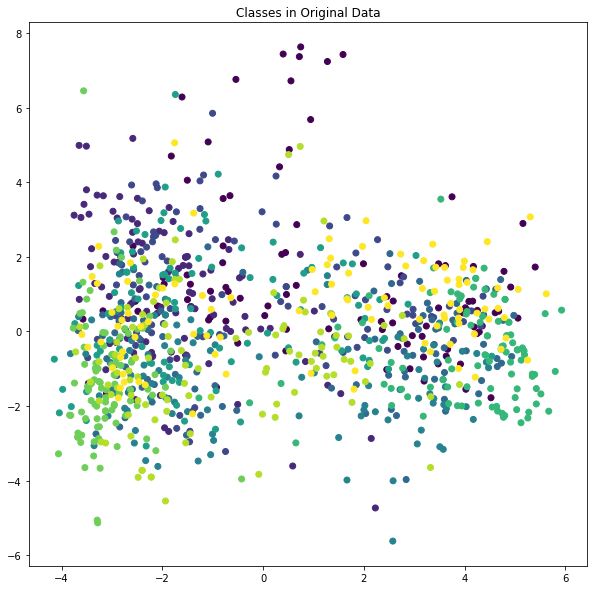

In [9]:
plt.figure(figsize=(10, 10))
plt.scatter(X_2d.T[0], X_2d.T[1], c=np.unique(y, return_inverse=True)[1], marker='o')
plt.title('Classes in Original Data')
plt.show()

---

# 4. Base Model

## 4.1 Fit base model

In [10]:
base = AgglomerativeClustering(n_clusters=10, linkage='ward', compute_distances=True).fit(X)

## 4.2 View base model

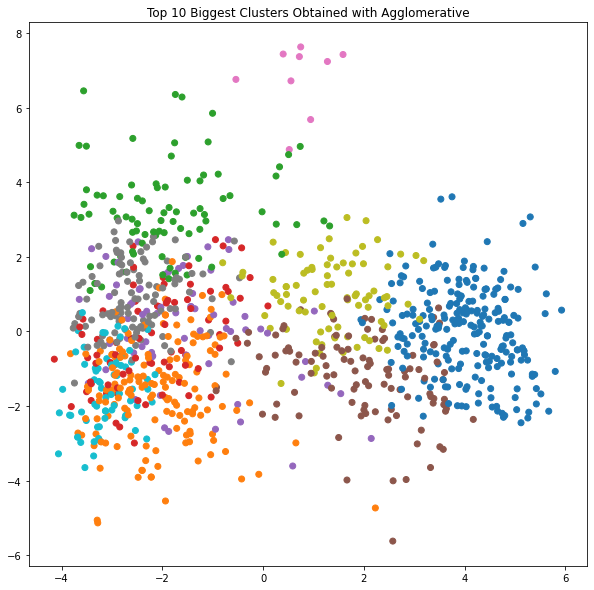

In [11]:
color = ListedColormap(plt.rcParams['axes.prop_cycle'].by_key()['color'])
plt.figure(figsize=(10, 10))
plt.scatter(X_2d.T[0], X_2d.T[1], c=base.labels_, cmap=color, marker='o')
plt.title('Top 10 Biggest Clusters Obtained with Agglomerative')
plt.show()

In [12]:
print(f'Adjusted random-index score for base model:\t{metrics.adjusted_rand_score(y,base.labels_)}')
print(f'Fowlkes-Mallows score for base model:\t{metrics.fowlkes_mallows_score(y,base.labels_)}')
print(f'Silhouette score for base model:\t{metrics.silhouette_score(X=X,labels=base.labels_,sample_size=800,random_state=123)}')
print(f'Davies-Bouldin score for base model:\t{metrics.davies_bouldin_score(X,base.labels_)}')

Adjusted random-index score for base model:	0.16623795285932585
Fowlkes-Mallows score for base model:	0.26287420991759797
Silhouette score for base model:	0.10786102533162517
Davies-Bouldin score for base model:	2.0331003299288746


Interpretation:<br>
Adjusted for chance, 17% of the clusters are assigned to the same groundtruth class.<br>
With confusion matrix, 26% of the clusters are similar to the groundtruth class.<br>
Silhouette score suggests that clusters are more likely to be overlapping than dense-seperation.<br>
The average similarity between clusters are 2, indicating very poor seperation.

Hence, we should continues to parameters tuning.

---

# 5. Extreme Value Theorem Optimization

## 5.1 Obtain optimal distance threshold

In [13]:
all_clusters = AgglomerativeClustering(n_clusters=None, linkage='ward', distance_threshold=0, compute_distances=True).fit(X)

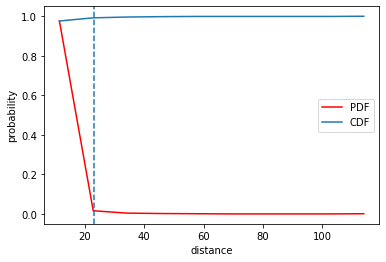

In [14]:
count, bins_count = np.histogram(all_clusters.distances_)
pdf = count / sum(count)
cdf = np.cumsum(pdf)
plt.plot(bins_count[1:], pdf, color="red", label="PDF")
plt.plot(bins_count[1:], cdf, label="CDF")
plt.axvline(x=23, linestyle='dashed')
plt.xlabel('distance')
plt.ylabel('probability')
plt.legend()

I.e. clusters obtained with picking `distance_threshold = 23` should be the optimal setting.

## 5.2 EV optimised model fit:

In [15]:
ev_model = AgglomerativeClustering(n_clusters=None, linkage='ward', distance_threshold=23, compute_distances=True).fit(X)

In [16]:
ev_model.n_clusters_

9

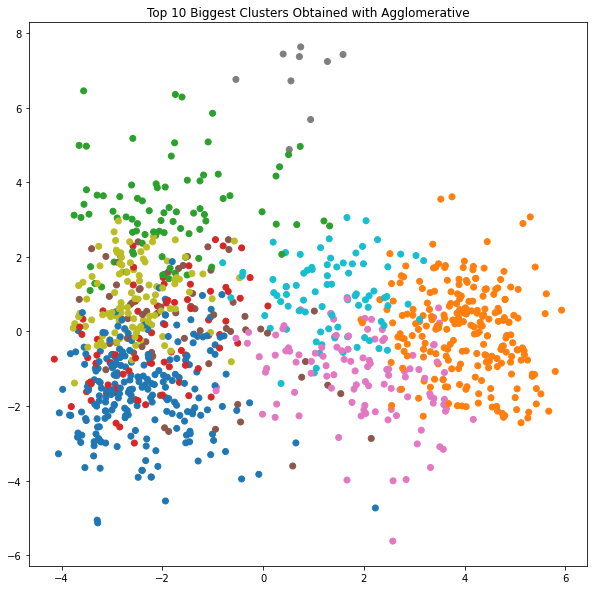

In [17]:
color = ListedColormap(plt.rcParams['axes.prop_cycle'].by_key()['color'])
plt.figure(figsize=(10, 10))
plt.scatter(X_2d.T[0], X_2d.T[1], c=ev_model.labels_, cmap=color, marker='o')
plt.title('Top 10 Biggest Clusters Obtained with Agglomerative')
plt.show()

In [18]:
print(f'Adjusted random-index score for EV model:\t{metrics.adjusted_rand_score(y,ev_model.labels_)}')
print(f'Fowlkes-Mallows score for EV model:\t{metrics.fowlkes_mallows_score(y,ev_model.labels_)}')
print(f'Silhouette score for EV model:\t{metrics.silhouette_score(X=X,labels=ev_model.labels_,sample_size=800,random_state=123)}')
print(f'Davies-Bouldin score for EV model:\t{metrics.davies_bouldin_score(X,ev_model.labels_)}')

Adjusted random-index score for EV model:	0.16307794903640174
Fowlkes-Mallows score for EV model:	0.269931192073383
Silhouette score for EV model:	0.11853939950177333
Davies-Bouldin score for EV model:	1.9998664042542391


Slightly better seperation, with better similarity between groundtruth class and obtained clusters.

---

# 6. Grid Search

Max distance:

In [19]:
max(AgglomerativeClustering(n_clusters=None, linkage='ward', distance_threshold=23, compute_distances=True).fit(X).distances_)

114.0140215401505

## 6.1 `number_of_clusters` Search

In [20]:
n_clusters = []
ri_scores = []
fmi_scores = []
s_scores = []
db_scores = []
for nc in range(2,21):
    m = AgglomerativeClustering(n_clusters=nc, linkage='ward').fit(X)
    n_clusters.append(m.n_clusters_)
    ri_scores.append(metrics.adjusted_rand_score(y,m.labels_))
    fmi_scores.append(metrics.fowlkes_mallows_score(y,m.labels_))
    s_scores.append(metrics.silhouette_score(X=X,labels=m.labels_,sample_size=800,random_state=123))
    db_scores.append(metrics.davies_bouldin_score(X,m.labels_))

Text(0.5, 1.0, 'DB Score')

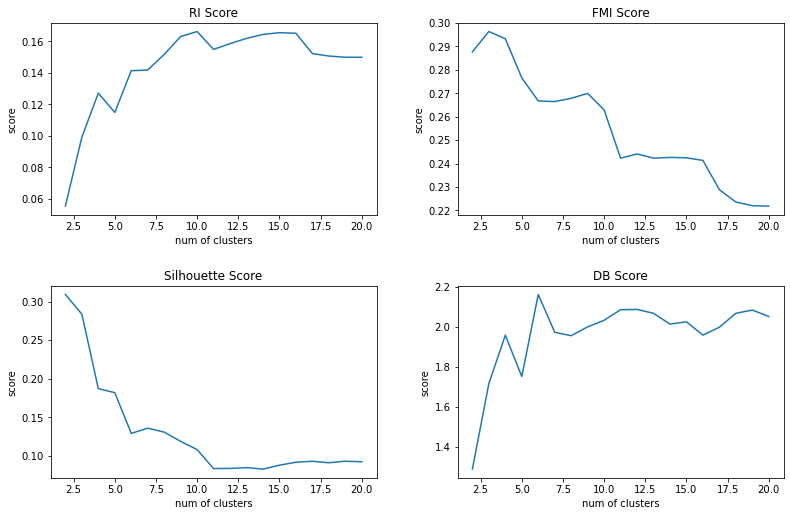

In [21]:
fig, ax = plt.subplots(2,2, figsize=(12, 8))
fig.tight_layout(pad=5)
ax[0,0].plot(n_clusters, ri_scores)
ax[0,0].set(xlabel='num of clusters', ylabel='score')
ax[0,0].set_title('RI Score')
ax[0,1].plot(n_clusters, fmi_scores)
ax[0,1].set(xlabel='num of clusters', ylabel='score')
ax[0,1].set_title('FMI Score')
ax[1,0].plot(n_clusters, s_scores)
ax[1,0].set(xlabel='num of clusters', ylabel='score')
ax[1,0].set_title('Silhouette Score')
ax[1,1].plot(n_clusters, db_scores)
ax[1,1].set(xlabel='num of clusters', ylabel='score')
ax[1,1].set_title('DB Score')

Except RI score, all other scoring metrics suggested that the lower number of clusters would be the best seperation. However, RI score suggested that either 10 or 15 clusters are the closest similarity to the groundtruth.

## 6.2 `distance_threshold` Search

In [22]:
thresholds = []
ri_scores = []
fmi_scores = []
s_scores = []
db_scores = []
for th in range(1,114):
    m = AgglomerativeClustering(n_clusters=None, distance_threshold=th, linkage='ward').fit(X)
    thresholds.append(th)
    ri_scores.append(metrics.adjusted_rand_score(y,m.labels_))
    fmi_scores.append(metrics.fowlkes_mallows_score(y,m.labels_))
    s_scores.append(metrics.silhouette_score(X=X,labels=m.labels_,sample_size=800,random_state=123))
    db_scores.append(metrics.davies_bouldin_score(X,m.labels_))

Text(0.5, 1.0, 'DB Score')

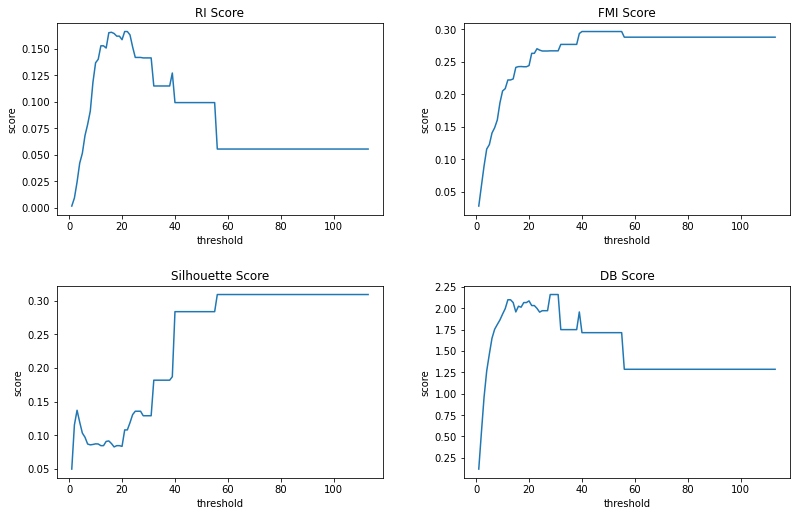

In [23]:
fig, ax = plt.subplots(2,2, figsize=(12, 8))
fig.tight_layout(pad=5)
ax[0,0].plot(thresholds, ri_scores)
ax[0,0].set(xlabel='threshold', ylabel='score')
ax[0,0].set_title('RI Score')
ax[0,1].plot(thresholds, fmi_scores)
ax[0,1].set(xlabel='threshold', ylabel='score')
ax[0,1].set_title('FMI Score')
ax[1,0].plot(thresholds, s_scores)
ax[1,0].set(xlabel='threshold', ylabel='score')
ax[1,0].set_title('Silhouette Score')
ax[1,1].plot(thresholds, db_scores)
ax[1,1].set(xlabel='threshold', ylabel='score')
ax[1,1].set_title('DB Score')

Except RI, all other scoring metrics suggest that setting the threshold high would show better seperation and better similarity to groundtruth class. However, RI suggests that setting the threshold to either 18 or 21 would have the optimal similarity to the groundtruth.

That is, if we want to have clusters that are more similar to the groundtruth classes, we set the threshold = 21, which in this case happens to be 10 clusters, i.e. the same number as the ground truth.

If solely based on internal information, to obtain the best seperation, we should set the threshold to as high as possible, i.e. as few clusters as possible, which indicates that our data is already very dense.<br>
Only obtaining 1 cluster means that we have done nothing in clssification, which is not what we want.

However, both Silhouette and DB score do suggest a second best local optimum, which is setting the number of clusters to 5 found with grid search, and 9 which is found with EV.

---

# 7. Model Exploratory Analysis

We have our 2 model, one with 10 clusters, and the other with 5 clusters, we can regard them as parent and child model, where the predicted labels are within the parent model:

In [55]:
parent_mod = AgglomerativeClustering(n_clusters=5, linkage='ward', compute_distances = True).fit(X)
child_mod = AgglomerativeClustering(n_clusters=10, linkage='ward', compute_distances = True).fit(X)

## 7.1 Dendrogram

Create function for dendrogram plotting:

In [25]:
def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack(
        [model.children_, model.distances_, counts]
    ).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)

Plot dendrogram for the parent model:

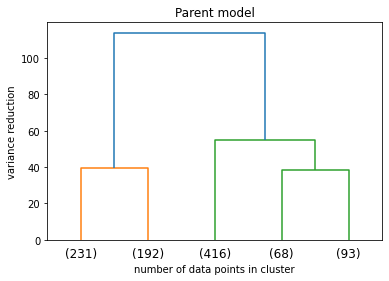

In [56]:
plt.title("Parent model")
plot_dendrogram(parent_mod, truncate_mode="lastp", p=5)
plt.xlabel("number of data points in cluster")
plt.ylabel("variance reduction")
plt.show()

In [57]:
print(f'Adjusted random-index score for parent model:\t{metrics.adjusted_rand_score(y,parent_mod.labels_)}')
print(f'Fowlkes-Mallows score for parent model:\t{metrics.fowlkes_mallows_score(y,parent_mod.labels_)}')
print(f'Silhouette score for parent model:\t{metrics.silhouette_score(X=X,labels=parent_mod.labels_,sample_size=800,random_state=123)}')
print(f'Davies-Bouldin score for parent model:\t{metrics.davies_bouldin_score(X,parent_mod.labels_)}')

Adjusted random-index score for parent model:	0.11483943511201125
Fowlkes-Mallows score for parent model:	0.2765579345278742
Silhouette score for parent model:	0.18178089800891506
Davies-Bouldin score for parent model:	1.7512195046619272


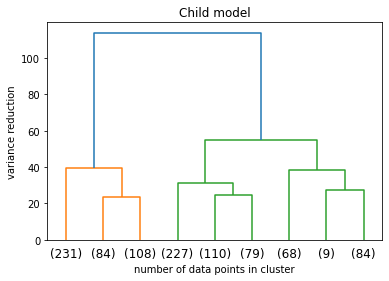

In [58]:
plt.title("Child model")
plot_dendrogram(child_mod, truncate_mode="lastp", p=9)
plt.xlabel("number of data points in cluster")
plt.ylabel("variance reduction")
plt.show()

In [59]:
print(f'Adjusted random-index score for parent model:\t{metrics.adjusted_rand_score(y,child_mod.labels_)}')
print(f'Fowlkes-Mallows score for parent model:\t{metrics.fowlkes_mallows_score(y,child_mod.labels_)}')
print(f'Silhouette score for parent model:\t{metrics.silhouette_score(X=X,labels=child_mod.labels_,sample_size=800,random_state=123)}')
print(f'Davies-Bouldin score for parent model:\t{metrics.davies_bouldin_score(X,child_mod.labels_)}')

Adjusted random-index score for parent model:	0.16623795285932585
Fowlkes-Mallows score for parent model:	0.26287420991759797
Silhouette score for parent model:	0.10786102533162517
Davies-Bouldin score for parent model:	2.0331003299288746


## 7.2 Child Clusters Exploratory

In [164]:
for i in range(0,1000,100):
    print(y[i])
    print(f'\tRI = \t{metrics.rand_score(y[i:i+100],child_mod.labels_[i:i+100])}')
    print(f'\tFMI = \t{metrics.fowlkes_mallows_score(y[i:i+100],child_mod.labels_[i:i+100])}')

blues
	RI = 	0.23232323232323232
	FMI = 	0.48199920365414745
classical
	RI = 	0.4307070707070707
	FMI = 	0.6562827673397121
country
	RI = 	0.1511111111111111
	FMI = 	0.38873012632302
disco
	RI = 	0.21818181818181817
	FMI = 	0.46709936649691375
hiphop
	RI = 	0.28565656565656566
	FMI = 	0.5344684889276127
jazz
	RI = 	0.1317171717171717
	FMI = 	0.36292860415951195
metal
	RI = 	0.7775757575757576
	FMI = 	0.8818025615611227
pop
	RI = 	0.35494949494949496
	FMI = 	0.5957763799862286
reggae
	RI = 	0.20525252525252524
	FMI = 	0.45304803857044257
rock
	RI = 	0.23535353535353534
	FMI = 	0.48513249257654895


In [133]:
def get_class_distribution(model, y):
    class_mtx = {}
    for i in range(len(y)):
        if model.labels_[i] not in class_mtx:
            class_mtx[model.labels_[i]] = []
            class_mtx[model.labels_[i]].append(y[i])
        else:
            class_mtx[model.labels_[i]].append(y[i])
    for k in class_mtx.copy().keys():
        freq_mtx = {}
        for i in class_mtx[k]:
            if i in freq_mtx:
                freq_mtx[i] += 1
            else:
                freq_mtx[i] = 1
        freq_mtx = dict(sorted(freq_mtx.items(), key=lambda item: item[1], reverse=True))
        class_mtx[k] = freq_mtx
    for i in class_mtx.keys():
        s = sum(class_mtx[i].values())
        for cl in class_mtx[i].keys():
            class_mtx[i][cl] = class_mtx[i][cl] / s
    return class_mtx

In [94]:
child_clusters = {}
for l in range(len(child_mod.labels_)):
    if child_mod.labels_[l] in child_clusters:
        child_clusters[child_mod.labels_[l]].append(l)
    else:
        child_clusters[child_mod.labels_[l]] = [l]

In [120]:
for k in child_clusters.keys():
    if k != 6:
        groundtruth = [y[i] for i in child_clusters[k]]
        yhat = [k for i in range(len(child_clusters[k]))]
        print(f'Cluster {k}:')
        print(f'\tRI = \t{metrics.rand_score(groundtruth, yhat)}')
        print(f'\tFMI = \t{metrics.fowlkes_mallows_score(groundtruth, yhat)}')
    else:
        print(f'Cluster {k}:')
        print('\t(noise cluster)')

Cluster 5:
	RI = 	0.18830044998269296
	FMI = 	0.4339359975649554
Cluster 8:
	RI = 	0.1491681009753299
	FMI = 	0.38622286438704
Cluster 3:
	RI = 	0.1973385264524505
	FMI = 	0.44422801178274485
Cluster 2:
	RI = 	0.2355134825014343
	FMI = 	0.48529731351145383
Cluster 6:
	(noise cluster)
Cluster 0:
	RI = 	0.2287972896668549
	FMI = 	0.47832759659761936
Cluster 1:
	RI = 	0.1581875352737241
	FMI = 	0.39772796642142744
Cluster 4:
	RI = 	0.7322212467076383
	FMI = 	0.8556992735229114
Cluster 7:
	RI = 	0.1372810675562969
	FMI = 	0.3705145983038953
Cluster 9:
	RI = 	0.5792838874680307
	FMI = 	0.7611070144651346


In [134]:
for k,v in get_class_distribution(child_mod, y).items():
    if k != 6:
        print(f'Cluster ID {k}:')
        print(v)
        print()
    else:
        print(f'Cluster ID {k}:')
        print('(noise cluster)')
        print()

Cluster ID 5:
{'hiphop': 0.2777777777777778, 'reggae': 0.2777777777777778, 'disco': 0.12962962962962962, 'jazz': 0.12037037037037036, 'blues': 0.06481481481481481, 'country': 0.05555555555555555, 'rock': 0.046296296296296294, 'metal': 0.027777777777777776}

Cluster ID 8:
{'country': 0.2261904761904762, 'rock': 0.2261904761904762, 'jazz': 0.16666666666666666, 'blues': 0.11904761904761904, 'metal': 0.07142857142857142, 'reggae': 0.07142857142857142, 'hiphop': 0.047619047619047616, 'classical': 0.03571428571428571, 'disco': 0.03571428571428571}

Cluster ID 3:
{'blues': 0.31645569620253167, 'jazz': 0.21518987341772153, 'reggae': 0.21518987341772153, 'country': 0.08860759493670886, 'pop': 0.06329113924050633, 'hiphop': 0.0379746835443038, 'disco': 0.02531645569620253, 'rock': 0.02531645569620253, 'classical': 0.012658227848101266}

Cluster ID 2:
{'classical': 0.36904761904761907, 'country': 0.21428571428571427, 'jazz': 0.21428571428571427, 'blues': 0.11904761904761904, 'reggae': 0.035714285

Reformat and showing only those overlapping genres with > 5% distribution:

In [136]:
for k,v in get_class_distribution(child_mod, y).items():
    if k != 6:
        print(f'Cluster ID {k}:')
        print({kk:str(round(vv*100,1))+'%' for kk,vv in v.items() if vv > 0.05})
        print()
    else:
        print(f'Cluster ID {k}:')
        print('(noise cluster)')
        print()

Cluster ID 5:
{'hiphop': '27.8%', 'reggae': '27.8%', 'disco': '13.0%', 'jazz': '12.0%', 'blues': '6.5%', 'country': '5.6%'}

Cluster ID 8:
{'country': '22.6%', 'rock': '22.6%', 'jazz': '16.7%', 'blues': '11.9%', 'metal': '7.1%', 'reggae': '7.1%'}

Cluster ID 3:
{'blues': '31.6%', 'jazz': '21.5%', 'reggae': '21.5%', 'country': '8.9%', 'pop': '6.3%'}

Cluster ID 2:
{'classical': '36.9%', 'country': '21.4%', 'jazz': '21.4%', 'blues': '11.9%'}

Cluster ID 6:
(noise cluster)

Cluster ID 0:
{'metal': '38.1%', 'rock': '16.9%', 'blues': '16.5%', 'disco': '16.0%', 'country': '6.1%'}

Cluster ID 1:
{'hiphop': '27.2%', 'reggae': '17.7%', 'pop': '15.8%', 'rock': '10.8%', 'disco': '10.1%', 'country': '7.6%', 'jazz': '7.0%'}

Cluster ID 4:
{'classical': '85.3%', 'jazz': '8.8%'}

Cluster ID 7:
{'country': '20.0%', 'disco': '17.3%', 'jazz': '14.5%', 'pop': '14.5%', 'rock': '13.6%', 'reggae': '9.1%', 'hiphop': '6.4%'}

Cluster ID 9:
{'pop': '75.4%', 'disco': '11.6%'}



Above would be the found rules of overlapping.

## 7.3 Parent Clusters Exploratory

In [137]:
parent_clusters = {}
for l in range(len(parent_mod.labels_)):
    if parent_mod.labels_[l] in parent_clusters:
        parent_clusters[parent_mod.labels_[l]].append(l)
    else:
        parent_clusters[parent_mod.labels_[l]] = [l]

In [162]:
for k in parent_clusters.keys():
    groundtruth_y = [y[i] for i in parent_clusters[k]]
    yhat = [k for i in range(len(parent_clusters[k]))]
    print(f'Cluster {k}:')
    print(f'\tRI = \t{metrics.rand_score(groundtruth_y, yhat)}')
    print(f'\tFMI = \t{metrics.fowlkes_mallows_score(groundtruth_y, yhat)}')

Cluster 1:
	RI = 	0.1324716404886562
	FMI = 	0.36396653759467534
Cluster 0:
	RI = 	0.13573911028730307
	FMI = 	0.3684278902136795
Cluster 2:
	RI = 	0.22136512388966806
	FMI = 	0.47049455245482713
Cluster 3:
	RI = 	0.2287972896668549
	FMI = 	0.47832759659761936
Cluster 4:
	RI = 	0.7322212467076383
	FMI = 	0.8556992735229114


In [143]:
for k,v in get_class_distribution(parent_mod, y).items():
    print(f'Cluster ID {k}:')
    print({kk:str(round(vv*100,1))+'%' for kk,vv in v.items() if vv > 0.05})
    print()

Cluster ID 1:
{'reggae': '18.8%', 'hiphop': '17.7%', 'jazz': '14.1%', 'country': '13.0%', 'rock': '12.5%', 'blues': '8.9%', 'disco': '8.9%'}

Cluster ID 0:
{'pop': '23.6%', 'reggae': '13.7%', 'hiphop': '13.2%', 'jazz': '11.3%', 'disco': '10.8%', 'country': '10.1%', 'rock': '8.4%', 'blues': '6.2%'}

Cluster ID 2:
{'classical': '33.3%', 'blues': '20.4%', 'country': '19.4%', 'jazz': '19.4%'}

Cluster ID 3:
{'metal': '38.1%', 'rock': '16.9%', 'blues': '16.5%', 'disco': '16.0%', 'country': '6.1%'}

Cluster ID 4:
{'classical': '85.3%', 'jazz': '8.8%'}

